# Модель машиннго обучения - XGBoost!!!

**Ссылки на ресурсы:**
* [Руководство по работе XGBoost.](https://qwertybox.ru/articles/54947/)
* [Introduction Regresion model](https://kirenz.github.io/regression/docs/xgboost-regression.html)
* [XGBoost](https://xgboost.readthedocs.io/en/stable/python/index.html)

In [1]:
# импортируем библиотеки
import pandas as pd # работа с данными / python data analysis library
import numpy as np # работа с числовыми данными / python numerical computing library
import seaborn as sns # визуализация данных / python data visualization library
import matplotlib.pyplot as plt # визуализация данных / python data visualization library

from sklearn.metrics import mean_absolute_error # метрика средняя абсолютная ошибка / mean absolute error
from sklearn.metrics import mean_squared_error # метрика средняя квадратичная ошибка / mean squared error
from sklearn.metrics import mean_absolute_percentage_error # метрика средняя абсолютная процентная ошибка / mean absolute percentage error

from sklearn.preprocessing import MinMaxScaler # алгоритм стандартизации данных / MinMaxScaler
from sklearn.preprocessing import StandardScaler # алгоритм стандартизации данных / StandardScaler

from sklearn.feature_selection import SelectKBest, f_regression # алгоритм для выбора признаков с наивысшими оценками в модели машинного обучения на основе статистических тестов / f-regression одномерный тест линейной регрессии  

from sklearn.model_selection import train_test_split # разделение выборки на обучающую и тестовую / train_test_split
from sklearn.model_selection import cross_val_score

import xgboost as xgb # модель XGBoost / model XGBoost
from xgboost import XGBRegressor # модель XGBoost Regressor / model XGBoost Regressor
from xgboost import DMatrix # формат матрицы наблюдений / DMatrix 

from joblib import dump, load # сохранение и загрузка модели / save and load model

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials # оптимизация гиперпараметров / hyperparameter optimization

import optuna #
optuna.logging.set_verbosity(optuna.logging.WARNING) # отключаем вывод промежуточных итогов вычислений

# отключаем предупреждения
import warnings 
warnings.filterwarnings("ignore")

# фиксируем RANDOM_SEED, для воспроизводимости кода.
RANDOM_SEED = 369


Тренировочная выборка:
     RMSE: 0.36
     MAE: 0.25
     MAPE: 1.96%
Валидационная выборка:
     RMSE: 0.39
     MAE: 0.26
     MAPE: 2.07%
Тестовая выборка:
     RMSE: 0.38
     MAE: 0.26
     MAPE: 2.06%


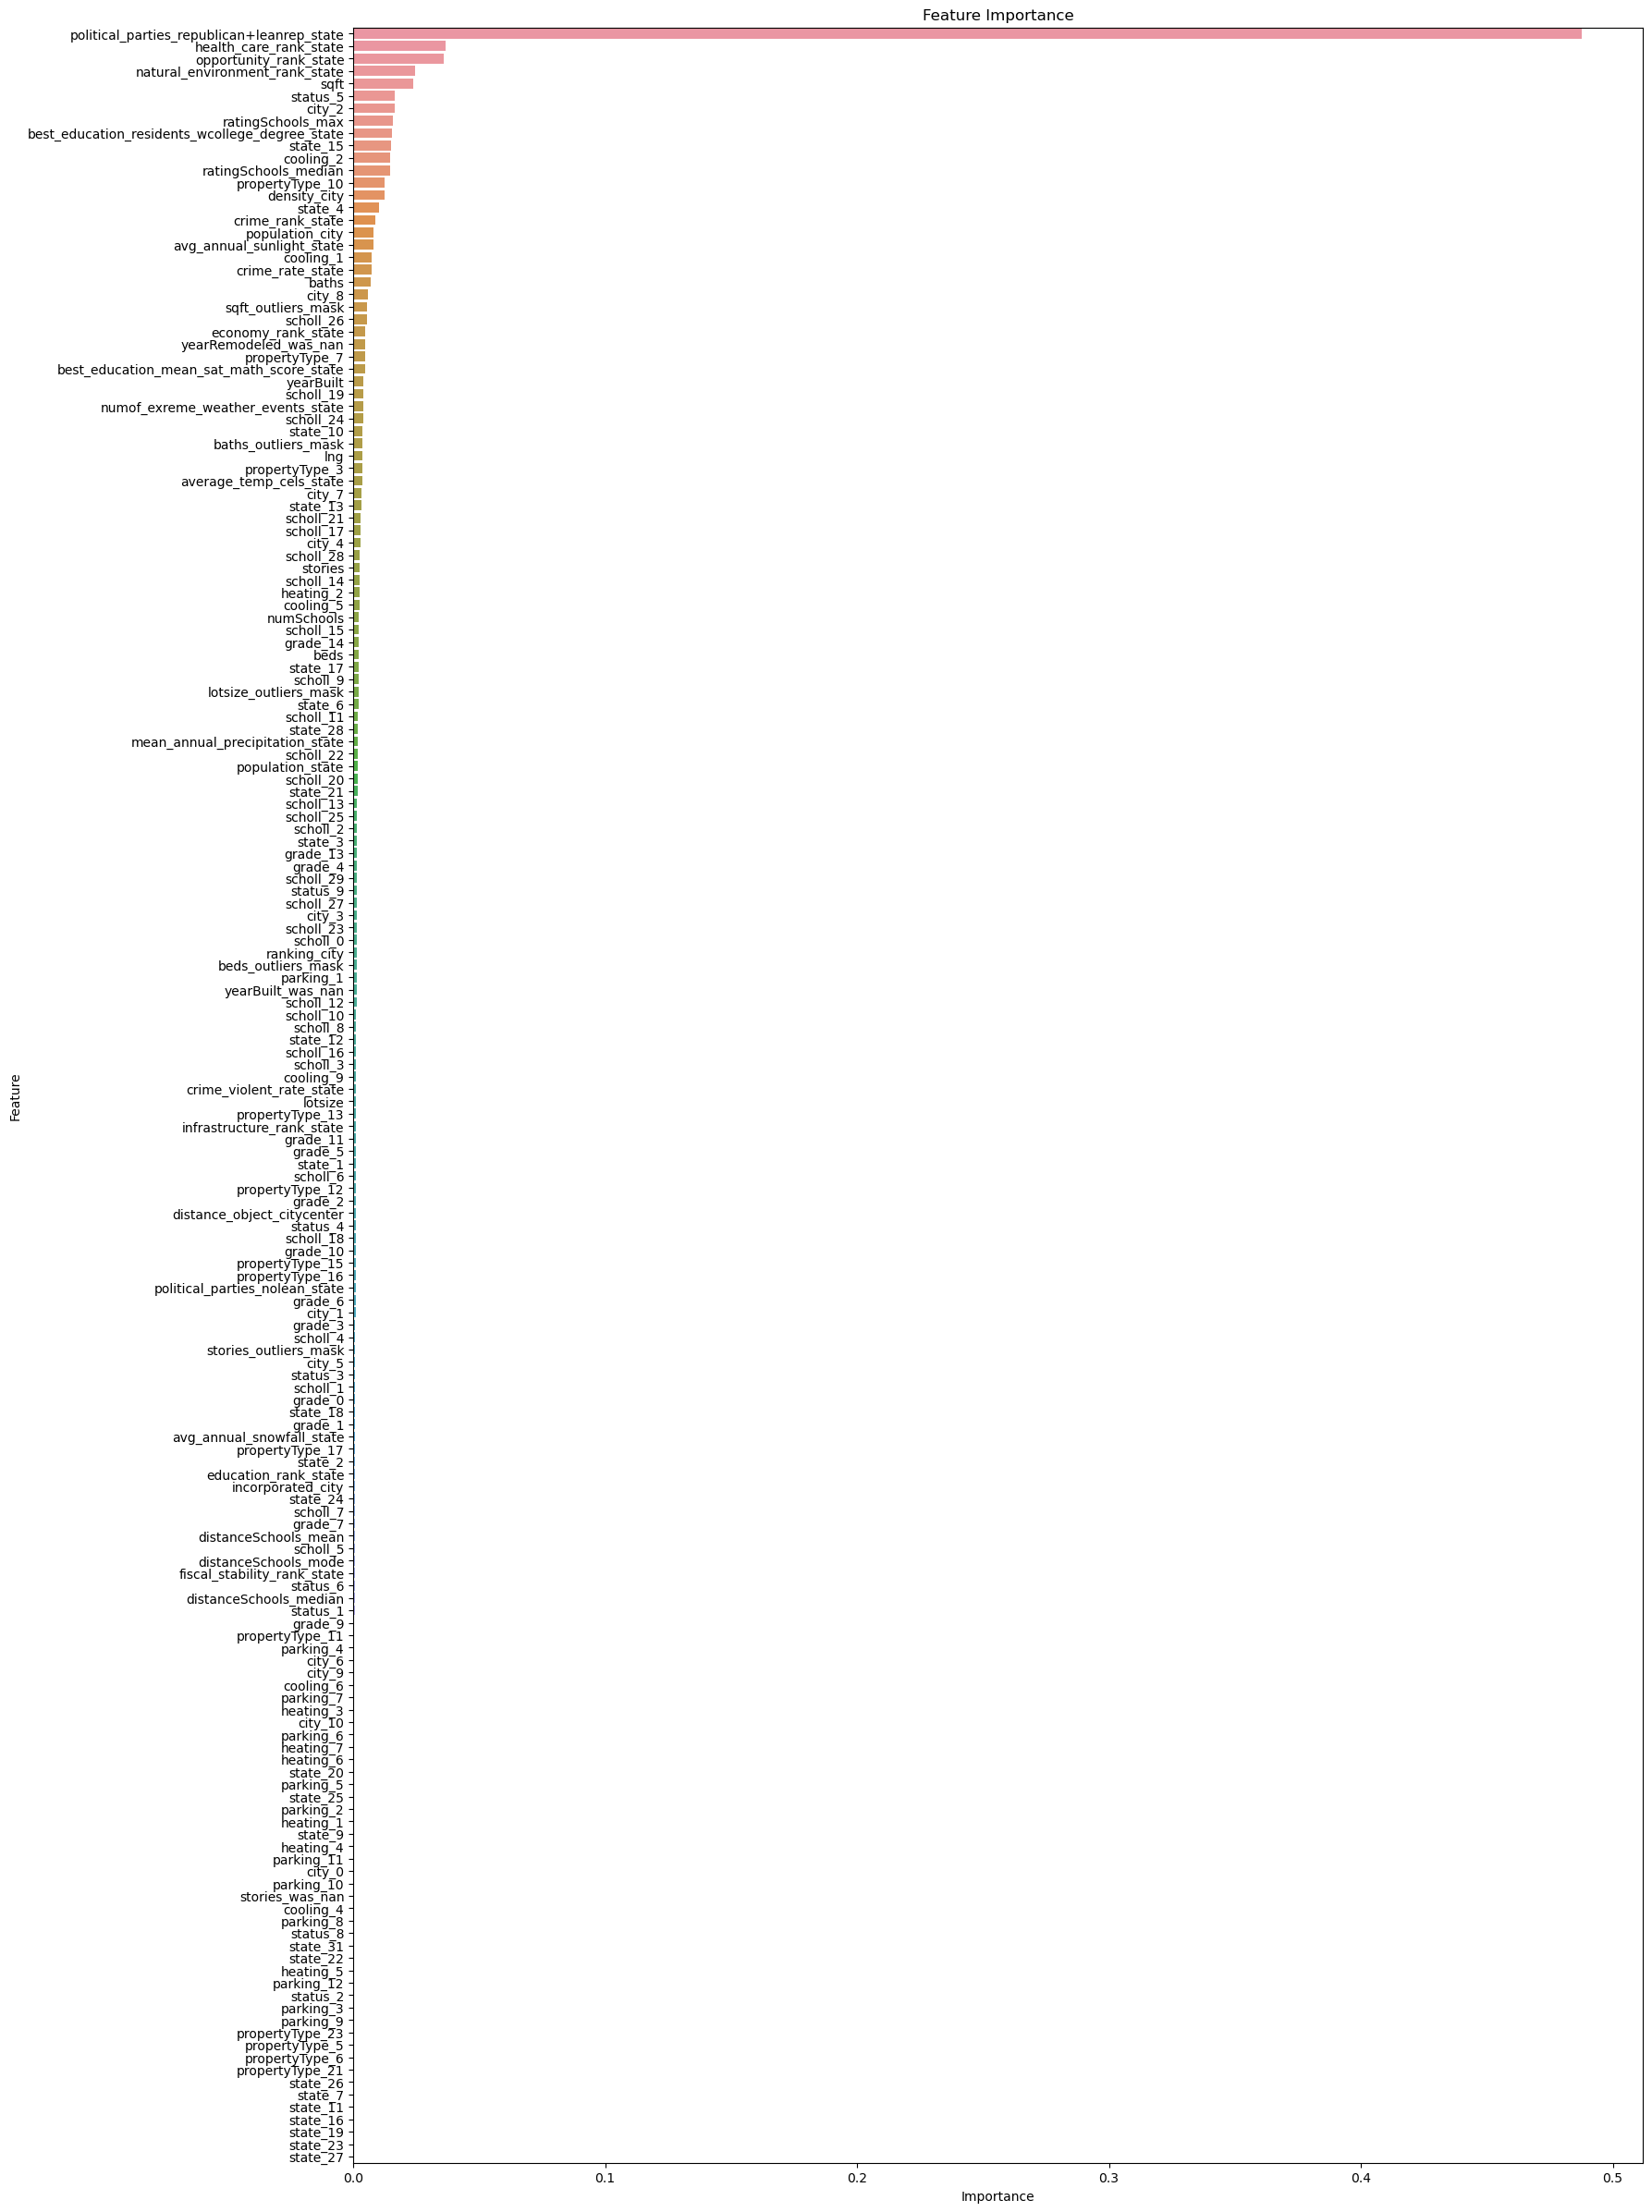

CPU times: user 51.7 s, sys: 6.14 s, total: 57.8 s
Wall time: 12.8 s


In [2]:
%%time
# загружаем данные
data_xgb = pd.read_csv("data/data_final.csv", sep=",")

# создаем матрицу наблюдений и вектор правильных ответов
X = data_xgb.drop(columns="target", axis=1)
y = data_xgb["target"]

# производим разделение выборки на тренировочную и тестовую
X_train, X_validtest, y_train, y_validtest = train_test_split(X, y, train_size=0.8, random_state=RANDOM_SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_validtest, y_validtest, test_size=0.5, random_state=RANDOM_SEED)

# #производим отбор наиболее важных признаков
# selector = SelectKBest(score_func=f_regression, k=50)
# selector.fit(X_train, y_train)
# best_features = selector.get_feature_names_out()
# X_train = X_train[best_features]
# X_valid = X_valid[best_features]
# X_test = X_test[best_features]

# формируем лист признаков для графика
feature_names = X_train.columns.tolist()

# производим нормализацию обучающей и тестовой выборки с помощью MinMaxScaller
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)
X_train = min_max_scaler.transform(X_train)
X_valid = min_max_scaler.transform(X_valid)
X_test = min_max_scaler.transform(X_test)

model_xgb = XGBRegressor(objective="reg:squarederror")
model_xgb.fit(X_train, y_train)

# делаем предсказание на тестовом наборе данных
y_train_predict_xgb = model_xgb.predict(X_train)
y_valid_predict_xgb = model_xgb.predict(X_valid)
y_test_predict_xgb = model_xgb.predict(X_test)

# выводим метрики оценки качества
print()
print("Тренировочная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_train_predict_xgb))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_train, y_train_predict_xgb)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_train, y_train_predict_xgb)*100))
print("Валидационная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_valid, y_valid_predict_xgb))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_valid, y_valid_predict_xgb)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_valid, y_valid_predict_xgb)*100))
print("Тестовая выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_test_predict_xgb))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_test, y_test_predict_xgb)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_test_predict_xgb)*100))

# График важности признаков с помощью библиотеки seaborn
feature_importance = model_xgb.feature_importances_
#feature_names = X.columns
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(18, 30))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance")
plt.show()

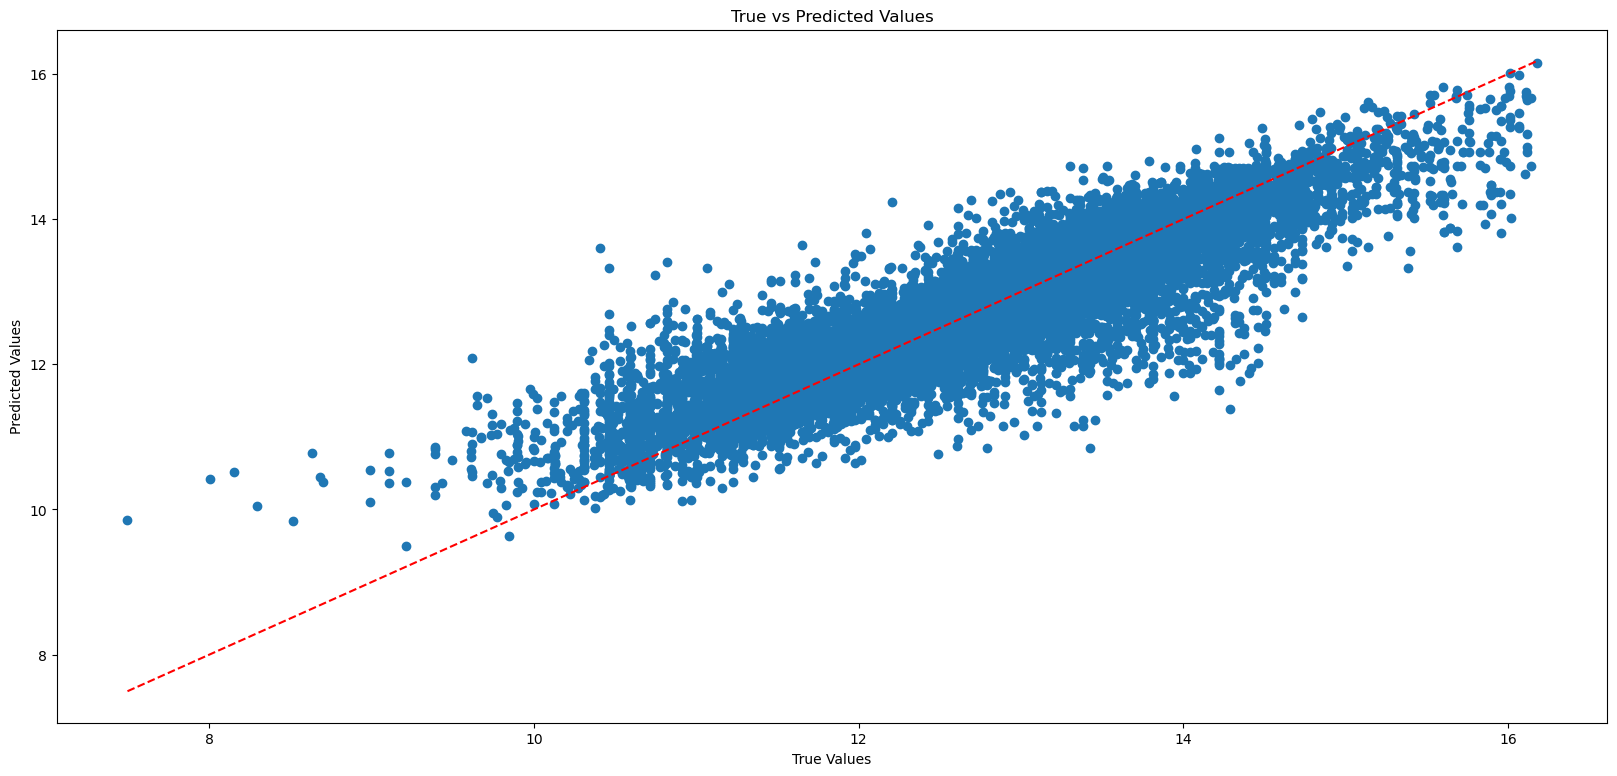

In [3]:
# график предсказанных значений против истинных значений на тестовой выборке
plt.figure(figsize=(20, 9))
plt.scatter(y_test, y_test_predict_xgb)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

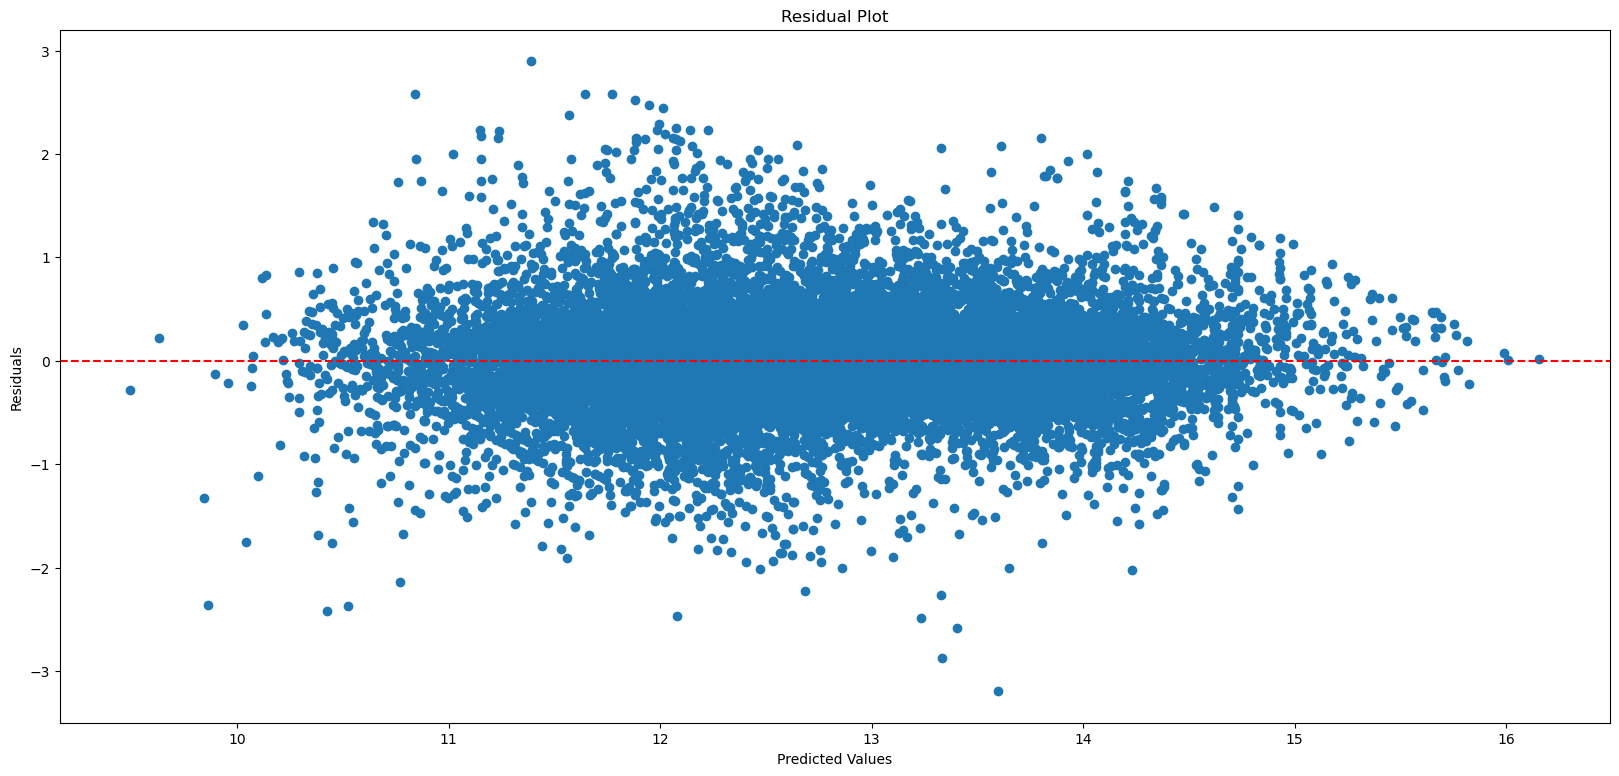

In [4]:
# график остатков
residuals = y_test - y_test_predict_xgb
plt.figure(figsize=(20, 9))
plt.scatter(y_test_predict_xgb, residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [5]:
# cохраняем модель в файл
dump(model_xgb, "model/model_XGBoost.joblib")

['model/model_XGBoost.joblib']

#### Optimization model - **OPTUNA** - Подбор гиперпараметров

In [6]:
%%time
# фломируем модель optuna для подбора гиперпараметров
def objective(trial):
    # задаем диапазон значений гиперпараметров
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 10, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True)
    }

    # обучаем модель с ранней остановкой
    optuna_xgb = XGBRegressor(**param)
    optuna_xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)

    # делаем предсказания на валидационных данных
    y_pred = optuna_xgb.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)

    # cообщаем оптимизатору текущий результат
    trial.report(mae, optuna_xgb.best_iteration)

    # проверяем, следует ли обрезать пробу
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return mae

# создаем и оптимизируем исследование с MedianPruner
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50, show_progress_bar=True)

# выводим лучшие параметры
best_params = study.best_trial.params
display(f"Лучшие параметры: {best_params}")

  0%|          | 0/50 [00:00<?, ?it/s]

"Лучшие параметры: {'n_estimators': 347, 'max_depth': 23, 'min_child_weight': 5, 'gamma': 0.0014654952231506482, 'learning_rate': 0.014105098280041405, 'colsample_bytree': 0.5214324180416751, 'subsample': 0.9038811134797002, 'alpha': 0.028550164513364885, 'lambda': 0.07448420680962642}"

CPU times: user 14h 51min 18s, sys: 5h 11min 47s, total: 20h 3min 5s
Wall time: 1h 52min 54s


In [7]:
%%time
# Обучаем модель XGBoost с подобранными параметрами Optuna
model_xgb_optuna = XGBRegressor(**best_params)
model_xgb_optuna.fit(X_train, y_train)

# делаем предсказание на тестовом наборе данных
y_train_predict_xgb_best = model_xgb_optuna.predict(X_train)
y_valid_predict_xgb_best = model_xgb_optuna.predict(X_valid)
y_test_predict_xgb_best = model_xgb_optuna.predict(X_test)

# выводим метрики оценки качества
print()
print("Тренировочная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_train_predict_xgb_best))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_train, y_train_predict_xgb_best)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_train, y_train_predict_xgb_best)*100))
print("Валидационная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_valid, y_valid_predict_xgb_best))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_valid, y_valid_predict_xgb_best)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_valid, y_valid_predict_xgb_best)*100))
print("Тестовая выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_test_predict_xgb_best))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_test, y_test_predict_xgb_best)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_test_predict_xgb_best)*100))


Тренировочная выборка:
     RMSE: 0.11
     MAE: 0.05
     MAPE: 0.41%
Валидационная выборка:
     RMSE: 0.33
     MAE: 0.19
     MAPE: 1.54%
Тестовая выборка:
     RMSE: 0.33
     MAE: 0.20
     MAPE: 1.55%
CPU times: user 2h 54s, sys: 54min 59s, total: 2h 55min 54s
Wall time: 17min 32s


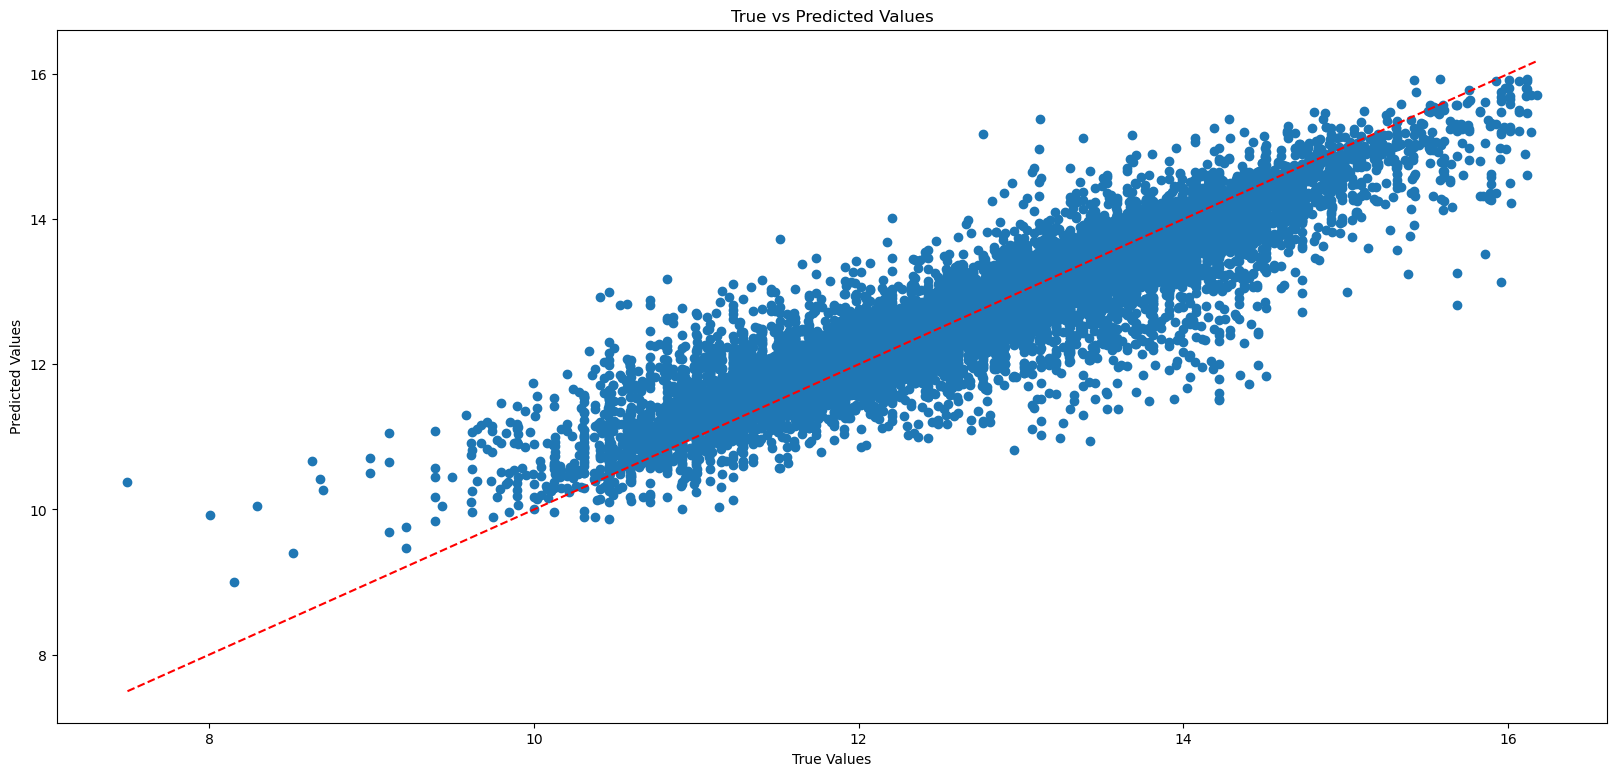

In [8]:
# график предсказанных значений против истинных значений
plt.figure(figsize=(20, 9))
plt.scatter(y_test, y_test_predict_xgb_best)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

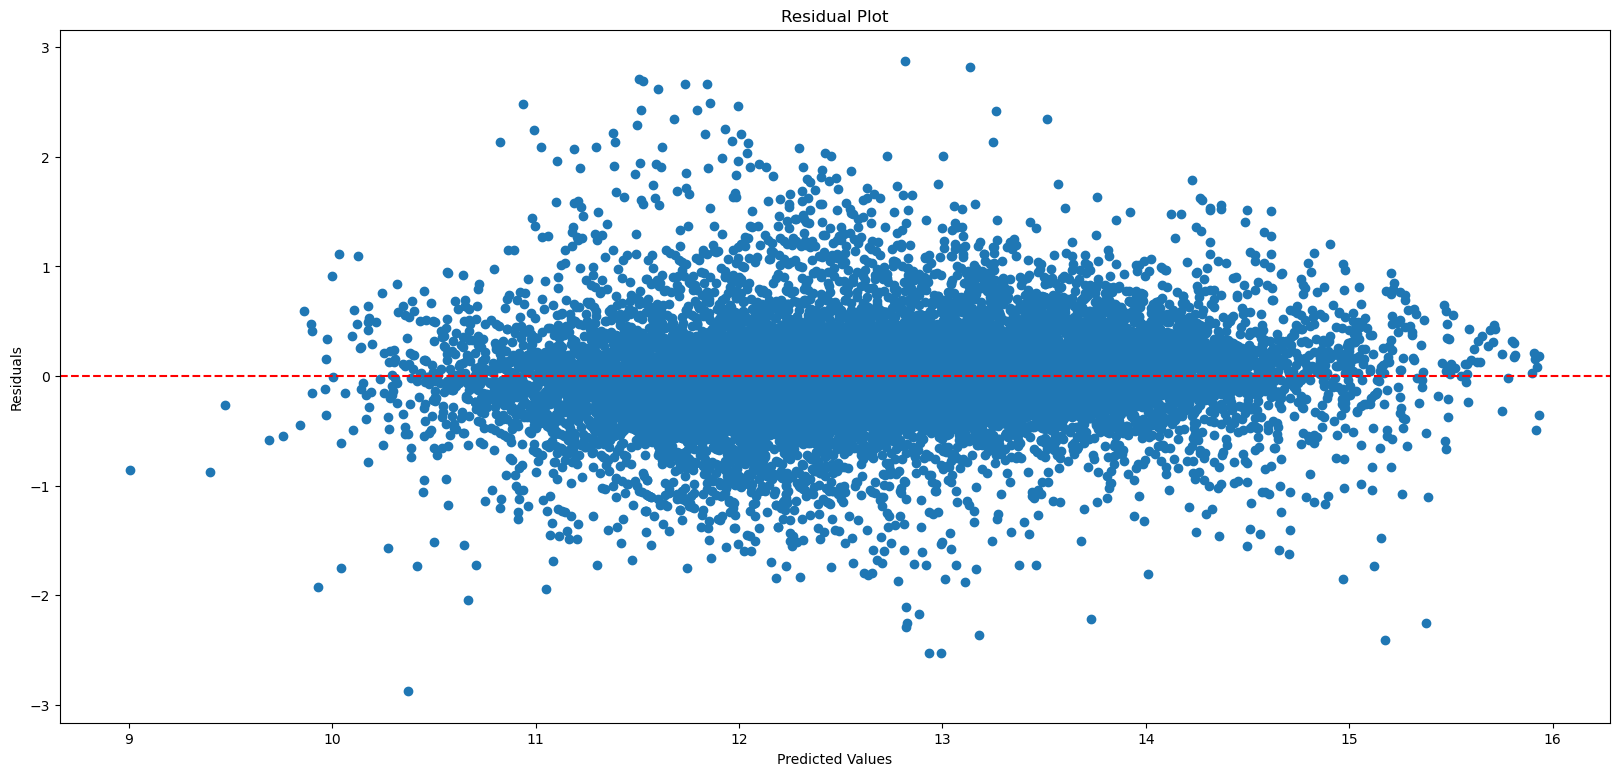

In [9]:
# график остатков
residuals = y_test - y_test_predict_xgb_best
plt.figure(figsize=(20, 9))
plt.scatter(y_test_predict_xgb_best, residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [10]:
# формируем и выводим график истории оптимизации
optuna.visualization.plot_optimization_history(study, target_name="mae")

In [11]:
# формируем и выводим график важности гиперпараметров
optuna.visualization.plot_param_importances(study, target_name="mae")

In [12]:
# визуализация контуров гиперпараметров
optuna.visualization.plot_contour(study, params=["learning_rate", "colsample_bytree"], target_name="mae")

In [13]:
# визуализация среза
optuna.visualization.plot_slice(study, target_name="mae")

In [14]:
# визуализация промежуточных значений (полезна, если вы используете промежуточные значения во время оптимизации)
optuna.visualization.plot_intermediate_values(study)


In [15]:
# визуализация прогресса оптимизации для параллельной координатной плоскости
optuna.visualization.plot_parallel_coordinate(study, target_name="mae")

In [16]:
# визуализация соотношения гиперпараметров к целевой метрике
optuna.visualization.plot_edf(study, target_name="mae")

In [17]:
# cохраняем модель в файл c подобранными гиперпараметрами
dump(model_xgb_optuna, "model/model_XGBoostOptuna.joblib")

['model/model_XGBoostOptuna.joblib']

#### Optimization model - **Hyperopt** - Подбор гиперпараметров

In [18]:
# определяем пространство поиска гиперпараметров
space = {
    "n_estimators": hp.quniform("n_estimators", 10, 500, 1),
    "max_depth": hp.quniform("max_depth", 3, 25, 1),
    "min_child_weight": hp.quniform("min_child_weight", 1, 300, 1),
    "gamma": hp.loguniform("gamma", -8, 0),  # эквивалент log=True в optuna
    "learning_rate": hp.loguniform("learning_rate", -8, 0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.1, 1.0),
    "subsample": hp.uniform("subsample", 0.1, 1.0),
    "alpha": hp.loguniform("alpha", -8, 1),  # log=True для alpha
    "lambda": hp.loguniform("lambda", -8, 1)  # log=True для lambda
}

# определяем функцию цели для Hyperopt
def objective(params):
    # конвертируем в целые числа параметры, которые должны быть целыми
    params["n_estimators"] = int(params["n_estimators"])
    params["max_depth"] = int(params["max_depth"])
    params["min_child_weight"] = int(params["min_child_weight"])
    
    # создаем и обучаем модель
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)
    
    # делаем предсказания и вычисляем ошибку
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    
    # возвращаем результат
    return {"loss": mae, "status": STATUS_OK}

# запускаем оптимизацию
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

# выводим лучшие параметры
print(f"Лучшие параметры: {best}")

100%|██████████| 30/30 [11:30<00:00, 23.01s/trial, best loss: 0.21537736697364793]
Лучшие параметры: {'alpha': 0.0007951883976451813, 'colsample_bytree': 0.769913096032785, 'gamma': 0.007902691734857059, 'lambda': 0.001905938083005223, 'learning_rate': 0.27318031960409833, 'max_depth': 12.0, 'min_child_weight': 29.0, 'n_estimators': 151.0, 'subsample': 0.983024330803777}


In [19]:
# продолжим подбор параметров, увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) и используем старый trials
best=fmin(objective, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(RANDOM_SEED) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 50/50 [11:28<00:00, 34.43s/trial, best loss: 0.20674407983417523]
Наилучшие значения гиперпараметров {'alpha': 0.009093985849867526, 'colsample_bytree': 0.9996309421995089, 'gamma': 0.009032233469237747, 'lambda': 0.0003531430903176216, 'learning_rate': 0.20116886420766655, 'max_depth': 13.0, 'min_child_weight': 74.0, 'n_estimators': 452.0, 'subsample': 0.9437990077254093}


In [20]:
# обучаем модель XGBoost с подобранными параметрами
best["max_depth"] = int(best["max_depth"])
best["n_estimators"] = int(best["n_estimators"])

model_xgb_hyperopt = XGBRegressor(**best)
model_xgb_hyperopt.fit(X_train, y_train)

# делаем предсказание на тестовом наборе данных
y_train_predict_xgb_hyp = model_xgb_hyperopt.predict(X_train)
y_valid_predict_xgb_hyp = model_xgb_hyperopt.predict(X_valid)
y_test_predict_xgb_hyp = model_xgb_hyperopt.predict(X_test)

# выводим метрики оценки качества
print()
print("Тренировочная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_train_predict_xgb_hyp))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_train, y_train_predict_xgb_hyp)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_train, y_train_predict_xgb_hyp)*100))
print("Валидационная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_valid, y_valid_predict_xgb_hyp))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_valid, y_valid_predict_xgb_hyp)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_valid, y_valid_predict_xgb_hyp)*100))
print("Тестовая выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_test_predict_xgb_hyp))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_test, y_test_predict_xgb_hyp)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_test_predict_xgb_hyp)*100))


Тренировочная выборка:
     RMSE: 0.17
     MAE: 0.11
     MAPE: 0.89%
Валидационная выборка:
     RMSE: 0.33
     MAE: 0.21
     MAPE: 1.64%
Тестовая выборка:
     RMSE: 0.33
     MAE: 0.21
     MAPE: 1.66%


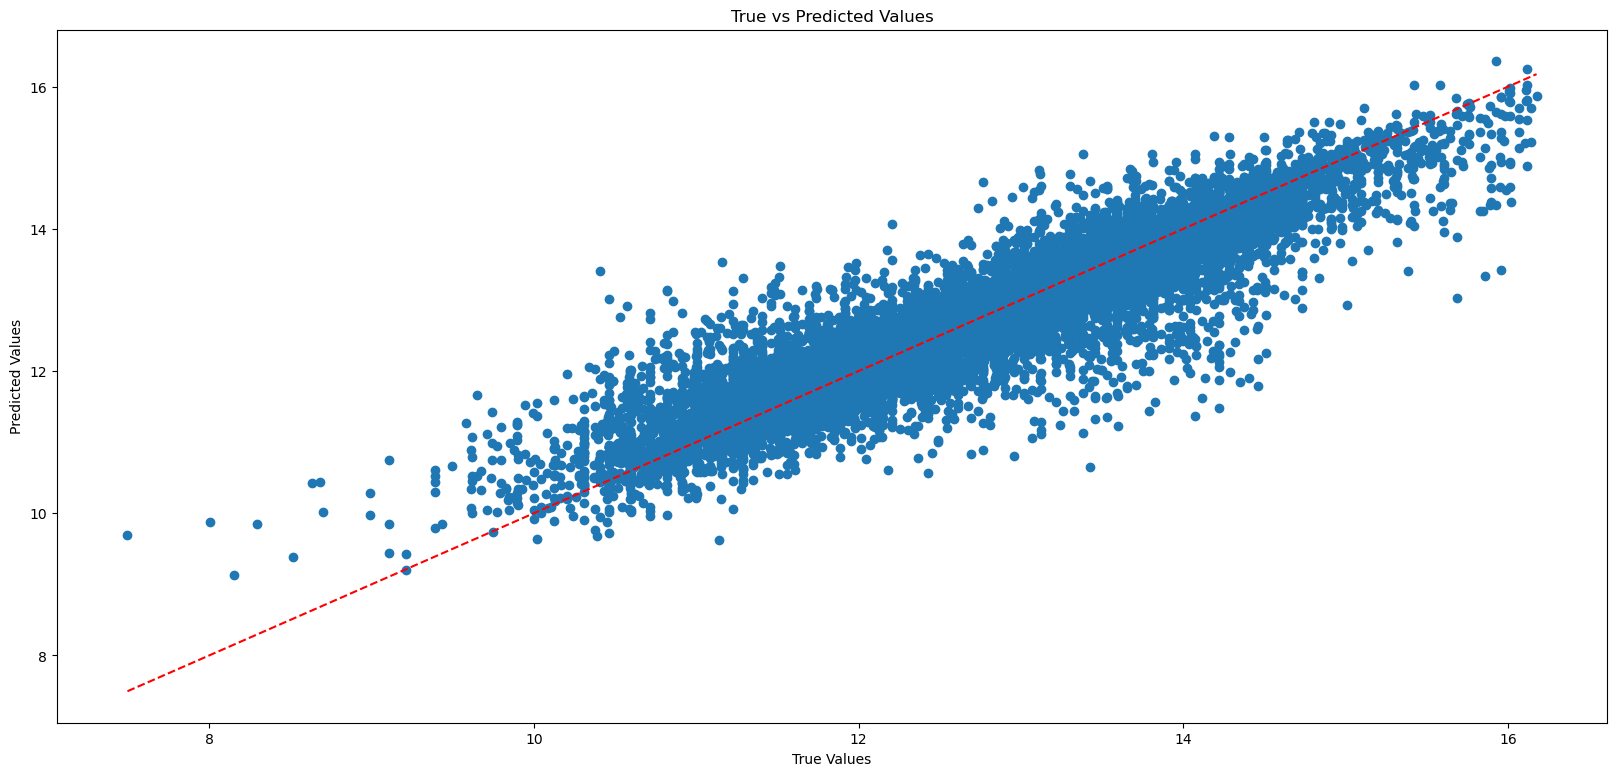

In [21]:
# график предсказанных значений против истинных значений
y_pred = y_test_predict_xgb_hyp
plt.figure(figsize=(20, 9))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

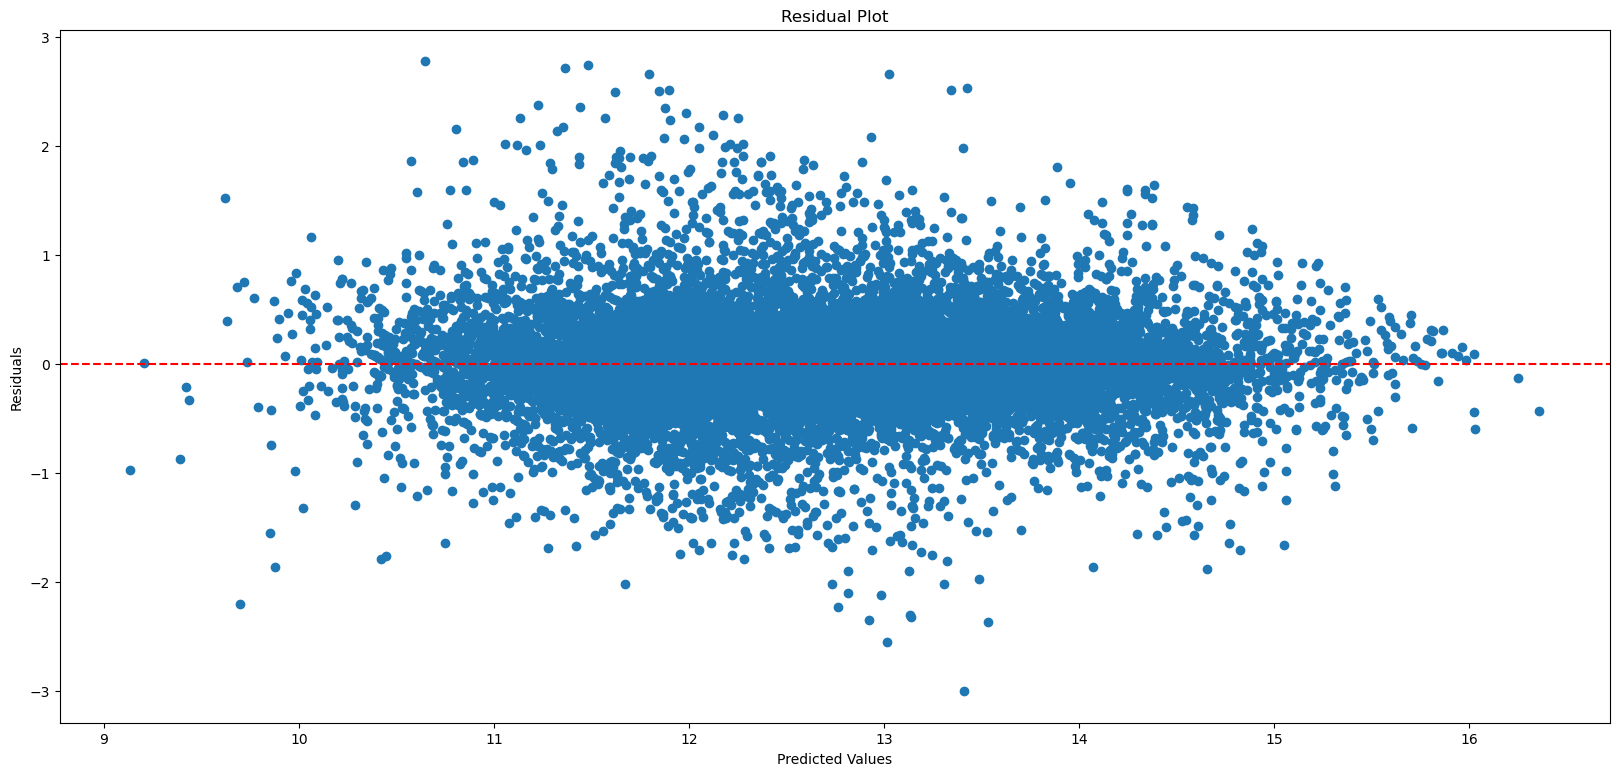

In [22]:
# график остатков
residuals = y_test - y_pred
plt.figure(figsize=(20, 9))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

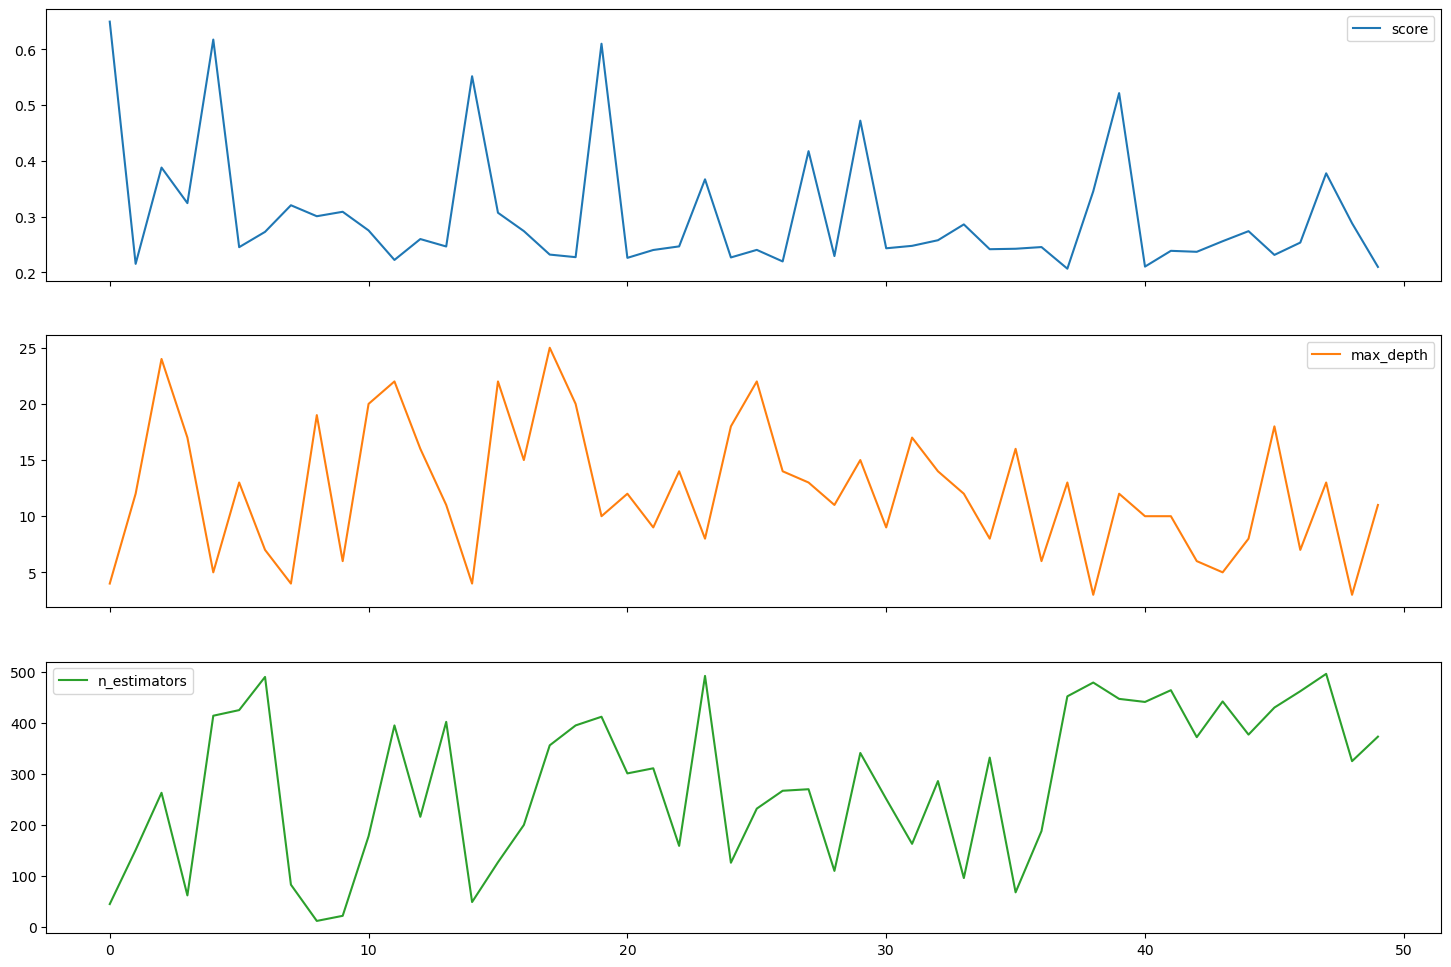

In [23]:
# формируем и выводим график, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x["result"]["loss"],
                      x["misc"]["vals"]["max_depth"][0],
                      x["misc"]["vals"]["n_estimators"][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=["score", "max_depth", "n_estimators"])
# тепловая карта в данном случае не наглядна, применяем линейный график
tpe_results_df.plot(subplots=True,figsize=(18, 12))
plt.show()

In [24]:
# cохраняем модель в файл c подобранными гиперпараметрами
dump(model_xgb_hyperopt, "model/model_XGBoostHyperopt.joblib")

['model/model_XGBoostHyperopt.joblib']

In [25]:
# в данную переменную буду сохранять результаты моделей [RSME, MAE, MAPE и название алгоритма]
results = []

# описываем функцию для оценки модели, а также для сохранения значений метрик и последующего использования
def results_model(model, X_train, y_train, X_valid, y_valid, X_test, y_test, model_name, results):
  """Функция для вывода результатов score для train, valid и test, а также для сохранения этих значений для последующего использования.
    
  Аргументы:
    model (model): обученная модель, которую необходимо оценить;
    model_name (string): название используемой модели.
  """
  model_result = []
  # предсказания и оценка для тренировочных данных
  y_train = np.expm1(y_train)
  y_train_pred = np.expm1(model.predict(X_train))
  RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3)
  MAE_train = mean_absolute_error(y_train, y_train_pred).round(3)
  MAPE_train = (mean_absolute_percentage_error(y_train, y_train_pred) * 100).round(3)
  # вывод результатов для тренировочных данных
  # print(f"Тренировочная выборка:")
  # print(f"    RMSE: {RMSE_train:.3f}")
  # print(f"    MAE: {MAE_train:.3f}")
  # print(f"    MAPE: {MAPE_train:.2f}%")
  
  # предсказания и оценка для валидационных данных
  y_valid = np.expm1(y_valid)
  y_valid_pred = np.expm1(model.predict(X_valid))
  RMSE_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred)).round(3)
  MAE_valid = mean_absolute_error(y_valid, y_valid_pred).round(3)
  MAPE_valid = (mean_absolute_percentage_error(y_valid, y_valid_pred) * 100).round(3)
  # вывод результатов для валидационных данных
  # print(f"Валидная выборка:")
  # print(f"    RMSE: {RMSE_valid:.3f}")
  # print(f"    MAE: {MAE_valid:.3f}")
  # print(f"    MAPE: {MAPE_valid:.2f}%")
  
  # предсказания и оценка для тестовых данных
  y_test = np.expm1(y_test)
  y_test_pred = np.expm1(model.predict(X_test))
  RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3)
  MAE_test = mean_absolute_error(y_test, y_test_pred).round(3)
  MAPE_test = (mean_absolute_percentage_error(y_test, y_test_pred) * 100).round(3)
  # вывод результатов для тестовых данных
  # print(f"Тестовая выборка:")
  # print(f"    RMSE: {RMSE_test:.3f}")
  # print(f"    MAE: {MAE_test:.3f}")
  # print(f"    MAPE: {MAPE_test:.2f}%") 
  
  # сохранение результатов в список model_results
  results.append({
      "RMSE_train": RMSE_train, "MAE_train": MAE_train, "MAPE_train": MAPE_train,
      "RMSE_valid": RMSE_valid, "MAE_valid": MAE_valid, "MAPE_valid": MAPE_valid,
      "RMSE_test": RMSE_test, "MAE_test": MAE_test, "MAPE_test": MAPE_test, 
      "ML_model": model_name
    })
  
  # сохранение результатов в список model_results
  model_result.append({
      "RMSE_train": RMSE_train, "MAE_train": MAE_train, "MAPE_train": MAPE_train,
      "RMSE_valid": RMSE_valid, "MAE_valid": MAE_valid, "MAPE_valid": MAPE_valid,
      "RMSE_test": RMSE_test, "MAE_test": MAE_test, "MAPE_test": MAPE_test, 
      "ML_model": model_name
    })
  
  # создаем dataframe с результатами
  resultmodelScoreData = pd.DataFrame(model_result).set_index('ML_model').sort_values(by='MAPE_test', ascending=True)
  # выводим сводную информацию 
  display(resultmodelScoreData.sort_values(by="MAE_test", ascending=True).round(2))

In [26]:
# делаем предсказания на тренировочной, валидной и тестовой выборках и выводим результат
print("Модель XGBoostRegressor:")
results_model(model_xgb, X_train, y_train, X_valid, y_valid, X_test, y_test, "XGBoostRegressor", results)
print()
print("Модель XGBoostRegressorOptuna - с подбором гиперпараметров (библиотека Optuna):")
results_model(model_xgb_optuna, X_train, y_train, X_valid, y_valid, X_test, y_test, "XGBoostRegressorOptuna", results)
print()
print("Модель XGBoostRegressorHyperopt - с подбором гиперпараметров (библиотека Hyperopt):")
results_model(model_xgb_hyperopt, X_train, y_train, X_valid, y_valid, X_test, y_test, "XGBoostRegressorHyperopt", results)

Модель XGBoostRegressor:


,RMSE_train,MAE_train,MAPE_train,RMSE_valid,MAE_valid,MAPE_valid,RMSE_test,MAE_test,MAPE_test
ML_model,,,,,,,,,
XGBoostRegressor,356716.76,130658.94,26.21,391054.16,142273.09,27.83,376833.67,138482.08,27.9



Модель XGBoostRegressorOptuna - с подбором гиперпараметров (библиотека Optuna):


,RMSE_train,MAE_train,MAPE_train,RMSE_valid,MAE_valid,MAPE_valid,RMSE_test,MAE_test,MAPE_test
ML_model,,,,,,,,,
XGBoostRegressorOptuna,177118.9,33975.63,5.28,349663.25,111400.69,20.81,340351.69,109344.17,20.97



Модель XGBoostRegressorHyperopt - с подбором гиперпараметров (библиотека Hyperopt):


,RMSE_train,MAE_train,MAPE_train,RMSE_valid,MAE_valid,MAPE_valid,RMSE_test,MAE_test,MAPE_test
ML_model,,,,,,,,,
XGBoostRegressorHyperopt,219580.83,64313.69,11.41,344261.7,115764.88,22.14,333429.65,114264.79,22.46


In [ ]:
# сформируем предсказание на всей выборке
y_pred = model_xgb_hyperopt.predict(X)
# выводим предсказние
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(np.expm1(y), np.expm1(y_pred)))))
print("     MAE: {:.2f}".format(mean_absolute_error(np.expm1(y), np.expm1(y_pred))))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(np.expm1(y), np.expm1(y_pred))*100))